# Diffmah
Run Andrew's diffmah model on halos from LJ to explore the smooth mass accretion history of different types of halos (fossils, non-fossils, rugs, etc.)

In [2]:
import copy
import h5py
import pickle
import numba
import numpy as np
import pandas as pd
import seaborn as sns
import haccytrees.mergertrees
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from itertools import groupby
from matplotlib.ticker import ScalarFormatter

from diffmah.diffmah.load_mah_data import load_tng_data, TASSO
from diffmah.diffmah.fit_mah_helpers import get_loss_data
from diffmah.diffmah.fit_mah_helpers import log_mah_mse_loss_and_grads
from diffmah.diffmah.utils import jax_adam_wrapper
from diffmah.diffmah.individual_halo_assembly import _calc_halo_history
from diffmah.diffmah.individual_halo_assembly import _get_early_late

redshifts = np.flip(np.array([10.044, 9.8065, 9.5789, 9.3608, 9.1515, 8.7573, 8.5714, 8.3925, 8.0541, 7.8938, 7.7391, 7.4454, 7.3058, 7.04, 6.9134, 6.6718, 6.5564, 6.3358, 6.1277, 6.028, 5.8367, 5.6556, 5.4839, 5.3208, 5.2422, 5.0909, 4.9467, 4.7429, 4.6145, 4.4918, 4.3743, 4.2618, 4.1015, 4.00, 3.8551, 3.763, 3.6313, 3.5475, 3.4273, 3.3133, 3.205, 3.102, 3.0361, 2.9412, 2.8506, 2.7361, 2.6545, 2.5765, 2.4775, 2.4068, 2.3168, 2.2524, 2.1703, 2.0923, 2.018, 1.9472, 1.8797, 1.7994, 1.7384, 1.68, 1.6104, 1.5443, 1.4938, 1.4334, 1.3759, 1.321, 1.2584, 1.2088, 1.152, 1.1069, 1.0552, 1.006, 0.9591, 0.9143, 0.8646, 0.824, 0.7788, 0.7358, 0.6948, 0.6557, 0.6184, 0.5777, 0.5391, 0.5022, 0.4714, 0.4337, 0.4017, 0.3636, 0.3347, 0.3035, 0.2705, 0.2423, 0.2123, 0.1837, 0.1538, 0.1279, 0.1008, 0.0749, 0.0502, 0.0245, 0.00]))

%load_ext line_profiler
%reload_ext autoreload
%autoreload 1
%aimport help_func_haccytrees
plt.rc('figure', facecolor='w')

pyfftw not available, using numpy fft


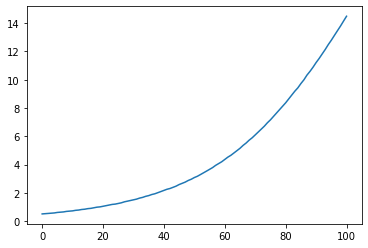

In [3]:
import diffmah
simulation = haccytrees.Simulation.simulations['LastJourney'] # read in a chunk of simulation
cosmic_time = simulation.cosmo.lookback_time(1e-10) - simulation.step2lookback(np.array(simulation.cosmotools_steps))
fig, ax = plt.subplots()
ax.plot(cosmic_time) # cosmic time vs timesteps

In [4]:
%%time
forest, progenitor_array = haccytrees.mergertrees.read_forest(
    '/data/a/cpac/mbuehlmann/LastJourney/forest/target_forest_aurora.hdf5',
    'LastJourney', nchunks=1, chunknum=0, mass_threshold = 2.7*10**11,
    include_fields = ["tree_node_mass", "snapnum", "fof_halo_tag", "sod_halo_cdelta", "fof_halo_center_x", "fof_halo_center_y", "fof_halo_center_z", "xoff_fof"]
)

CPU times: user 9.67 s, sys: 40.7 s, total: 50.4 s
Wall time: 1min 2s


In [5]:
%%time
fg_forest, fg_progenitor_array = haccytrees.mergertrees.read_forest(
    "/data/a/cpac/mbuehlmann/LastJourney/forest/fg_forest.hdf5",
    'LastJourney'
)

CPU times: user 32.1 s, sys: 13min 52s, total: 14min 24s
Wall time: 25min


## Get halo samples (via masking)

In [6]:
fg_masks = help_func_haccytrees.make_masks(fg_forest)
halo_masks = help_func_haccytrees.make_masks(forest) # All z=0 halos # Same as `halo_masks2 = make_masks(forest, target_idx = target_idx)` because of mass bins

### Helper Function

In [7]:
# Calculate their parameters
#import diffmah
#simulation = haccytrees.Simulation.simulations['LastJourney'] # read in a chunk of simulation
def calc_subset_params(subset, forest, log_mah_fit_min = np.log10(100*simulation.particle_mass)): #, non_fg_rugs_mrich): # mainbranch_peakmass, size, cosmic_time, min_mass, rs_fg_qh
    
    #print(subset)
    mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(subset, forest)
    mainbranch_peakmass = np.maximum.accumulate(mainbranch_masses, axis=1)
    mainbranch_peakmass[~np.isfinite(mainbranch_peakmass)] = 0
    mainbranch_peakmass = np.log10(mainbranch_peakmass)
    
    t_tng = simulation.cosmo.lookback_time(1e-10) - simulation.step2lookback(np.array(simulation.cosmotools_steps))
    size = len(subset)
    subset_params = np.zeros((size, 4)) # 5))
    
    for ihalo in range(size):
        p_init, loss_data = get_loss_data(t_tng, mainbranch_peakmass[ihalo], log_mah_fit_min) # np.log10(log_mah_sim[ihalo])
        n_step = 150 # or  200?
        _res = jax_adam_wrapper(log_mah_mse_loss_and_grads, p_init, loss_data, n_step, n_warmup=1)
        p_best, loss, loss_arr, params_arr, fit_terminates = _res
        logtc, ue, ul = p_best
        logt_target, log_mah_target, logtmp, k, logmp_fit = loss_data
        early, late = _get_early_late(ue, ul)
        tarr = np.linspace(0.75, 13.8, 500) # age of the universe things?
        lgtarr = np.log10(tarr)
        dmhdt_fit, log_mah_fit = _calc_halo_history(lgtarr, lgtarr[-1], logmp_fit, logtc, k, early, late) # Is logtc the new x0?
        subset_params[ihalo,:] = [logmp_fit, early, late, logtc] #, non_fg_rugs_mrich[ihalo]] # x0 is now logtc

    # Add on z50s, z80s, concentrations, and relaxations
    #print(subset_params)
    z50s = help_func_haccytrees.get_zfracs(forest, redshifts, subset, mainbranch_masses, frac = 0.5)
    z80s = help_func_haccytrees.get_zfracs(forest, redshifts, subset, mainbranch_masses, frac = 0.8)
    cdeltas = forest['sod_halo_cdelta'][subset] # Hopefully this is right?
    relaxations = forest['xoff_fof'][subset]
    subset_params = np.concatenate((subset_params, np.array([z50s]).T, np.array([z80s]).T, np.array([cdeltas]).T, np.array([relaxations]).T), axis = 1)
    #print(subset_params)

    return subset_params

# Multi-sample: The Main Event

#### Create a sample for each type of fossil status

In [8]:
%%time
# Pick a mass bin
mass_bin = 0
my_fg_mask = fg_masks[mass_bin]
my_halo_mask = halo_masks[mass_bin]

# Find qhs within fg_forest
fg_rugs_idx = np.nonzero(my_fg_mask)[0]
fg_rugs_mainbranch_index, fg_rugs_mainbranch_masses = help_func_haccytrees.get_branches(fg_rugs_idx, fg_forest)
fg_rugs_mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(fg_forest, fg_progenitor_array, fg_rugs_mainbranch_index)
fg_rugs_major_mergers = help_func_haccytrees.get_major_mergers(fg_rugs_mainbranch_mergers)
fg_rugs_lmm_redshift = help_func_haccytrees.get_lmms(fg_rugs_major_mergers)
fgs, qhs, mrich = help_func_haccytrees.find_specials(fg_forest, fg_rugs_mainbranch_index, fg_rugs_major_mergers, fg_rugs_lmm_redshift, fg_rugs_idx)

# Define sample sizes
rs_sample_size = 1000
fg_sample_size = 1000
if qhs != []:
    qh_sample_size = 1000 #len(rugs)
    size = fg_sample_size + qh_sample_size + rs_sample_size
else:
    qh_sample_size = 0 #len(rugs)
    size = fg_sample_size + rs_sample_size
    
# Create subsets
np.random.seed(0)
rs_idx = np.nonzero(my_halo_mask)[0]
rs_subset = np.random.choice(rs_idx, rs_sample_size)
fg_subset = np.random.choice(fg_rugs_idx, fg_sample_size)
if qhs != []:
    qh_subset = np.random.choice(qhs, qh_sample_size)

CPU times: user 4.44 s, sys: 1min 8s, total: 1min 12s
Wall time: 24 s


/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [138]:
practice = calc_subset_params(fg_subset[0:5], fg_forest) 

/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


In [146]:
forest.keys()

dict_keys(['tree_node_mass', 'snapnum', 'fof_halo_tag', 'sod_halo_cdelta', 'fof_halo_center_x', 'fof_halo_center_y', 'fof_halo_center_z', 'xoff_fof', 'tree_node_index', 'desc_node_index', 'branch_size', 'scale_factor', 'descendant_idx', 'progenitor_count', 'progenitor_offset', 'halo_index'])

In [147]:
%%time
#rs_tpeak = cosmic_time[np.argmax(rs_subset, axis=1)] # Do we still need this part?
rs_best_fit_params = calc_subset_params(rs_subset, forest) # p_init is shape of number of params. How many params do I have? 3 fg, rugs, rs, but are those really parameters?
fg_best_fit_params = calc_subset_params(fg_subset, fg_forest) 
qh_best_fit_params = calc_subset_params(qh_subset, fg_forest)

/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


CPU times: user 33min 58s, sys: 5min 29s, total: 39min 28s
Wall time: 28min 52s


In [160]:
rs_best_fit_params[0]

array([13.03588676,  3.85562968,  0.07935498,  0.47018793,  0.9591    ,
        0.6184    ,  6.55062199,  0.04351707])

In [148]:
qh_best_fit_params

array([[1.30503130e+01, 3.23859143e+00, 5.19648075e-01, ...,
        3.03500000e-01, 1.02426376e+01, 4.15703990e-02],
       [1.30262384e+01, 2.82346463e+00, 4.05655533e-01, ...,
        5.39100000e-01, 5.73891354e+00, 6.02751635e-02],
       [1.30418224e+01, 1.61339736e+00, 4.64668632e-01, ...,
        5.02200000e-01, 8.35682201e+00, 1.27042327e-02],
       ...,
       [1.30266628e+01, 2.31009889e+00, 4.17310894e-01, ...,
        3.34700000e-01, 6.29103279e+00, 4.78831381e-02],
       [1.30254402e+01, 1.96427679e+00, 6.66941941e-01, ...,
        2.70500000e-01, 6.84467459e+00, 5.14116213e-02],
       [1.30034266e+01, 3.78934121e+00, 3.42431158e-01, ...,
        5.77700000e-01, 8.17574978e+00, 2.83632446e-02]])

### Pickle those

In [161]:
pickle.dump(rs_best_fit_params, open( "save_new_rs_list.p", "wb" ))
pickle.dump(fg_best_fit_params, open( "save_new_fg_list.p", "wb" ))
pickle.dump(qh_best_fit_params, open( "save_new_qh_list.p", "wb" ))

In [18]:
pickled_rs_params = pickle.load( open( "save_new_rs_list.p", "rb" ))
pickled_fg_params = pickle.load( open( "save_new_fg_list.p", "rb" ))
pickled_qh_params = pickle.load( open( "save_new_qh_list.p", "rb" ))

## Check Accuracy

#### Individual halos

In [59]:
# convert redshifts to cosmic time
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
simulation = haccytrees.Simulation.simulations['LastJourney'] # read in a chunk of simulation
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.31)
cosmic_time = simulation.cosmo.lookback_time(1e-10) - simulation.step2lookback(np.array(simulation.cosmotools_steps))
cosmic_age = cosmo.age(redshifts).value #something like this?
print(np.log10(np.flip(cosmic_age)))
tarr = np.linspace(0.75, 13.8, 101)
lgtarr = np.log10(tarr)
print(lgtarr)
print(redshifts)

def get_fit_from_sample(subset_params):
    logmp_fit, early, late, logtc, __, __, __, __, = subset_params
    #tarr = np.linspace(0.75, 13.8, 101)
    #lgtarr = np.log10(tarr)
    lgtarr = np.log10(np.flip(cosmic_age))
    k = 3.5 # right?
    dmhdt_fit, log_mah_fit = _calc_halo_history(lgtarr, lgtarr[-1], logmp_fit, logtc, k, early, late)
    return lgtarr, log_mah_fit # not including logt_target, log_mah_target because I can get those (though not smooth)

[-0.32737214 -0.31321818 -0.29935977 -0.2857977  -0.27251223 -0.24673078
 -0.23420978 -0.22192906 -0.19804777 -0.1864228  -0.17500417 -0.15276045
 -0.14191599 -0.12075659 -0.11043227 -0.09026508 -0.08040812 -0.06114151
 -0.04243104 -0.03327367 -0.01533569  0.00211121  0.01909325  0.03564299
  0.0437703   0.05970437  0.07525979  0.09789314  0.11256422  0.12689698
  0.14092164  0.15463572  0.17468408  0.18770144  0.2067419   0.21913625
  0.23727392  0.24907942  0.26638924  0.28323493  0.29964457  0.31563645
  0.32607358  0.34139698  0.35636201  0.37576715  0.38994795  0.40378919
  0.42177747  0.43492405  0.4520383   0.46455551  0.48085503  0.4967105
  0.51216388  0.52722062  0.54188901  0.55975454  0.5736404   0.58719881
  0.60370814  0.61975428  0.63226355  0.64752001  0.66235278  0.67680601
  0.69364607  0.70727056  0.72318928  0.73607717  0.75112988  0.76573949
  0.77993243  0.79373941  0.80934979  0.82233686  0.83705031  0.85130293
  0.86512998  0.87853682  0.89153124  0.90594277  0.

/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/

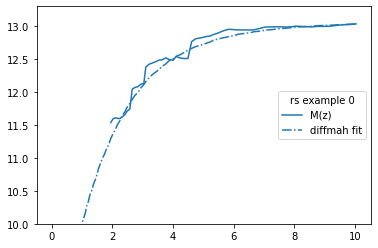

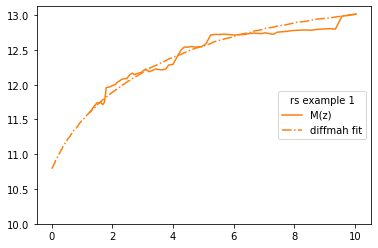

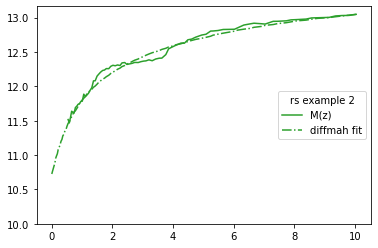

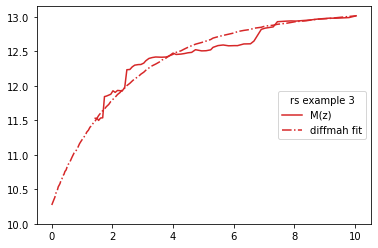

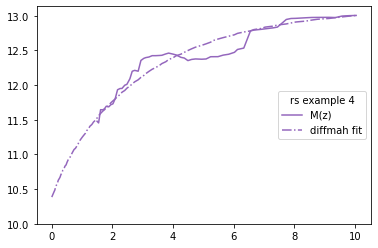

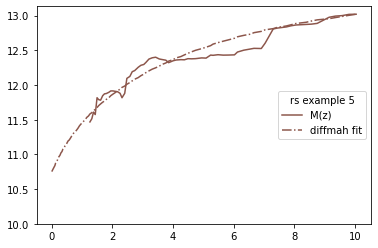

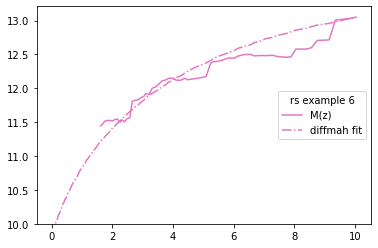

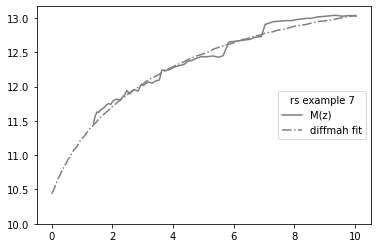

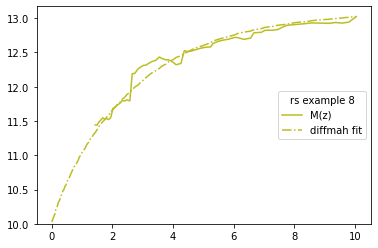

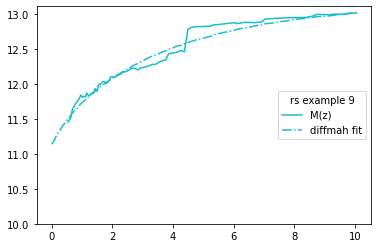

In [79]:
n = 10
category = "rs"
if category == "rs":
    my_subset = rs_subset
    my_forest = forest
    my_params = pickled_rs_params
elif category == "fg":
    my_subset = fg_subset
    my_forest = fg_forest
    my_params = pickled_fg_params
elif category == "qh":
    my_subset = qh_subset
    my_forest = fg_forest
    my_params = pickled_qh_params
    
colors = [plt.cm.tab10(i) for i in range(n)]
mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(my_subset[0:n], my_forest)
for i, params in enumerate(my_params[0:n]): # subset should already be random order
    fig, ax = plt.subplots(1, 1)
    lgtarr, log_mah_fit = get_fit_from_sample(params)
    # how to make redshifts line up with cosmic times?
    ax.plot(redshifts, np.log10(mainbranch_masses[i]), color = colors[i], label = "M(z)")
    ax.plot(redshifts, log_mah_fit, linestyle = "-.", color = colors[i], label = "diffmah fit") # diffmah fit
    ax.set_ylim(bottom = 10)   
    #if i == 0:
    ax.legend(title = category + " example " + str(i), loc = "center right")
    fig.savefig("diffmah_checks/" + category + "_individual_" + str(i) + ".png")
#fig.savefig("diffmah_checks/rs_batch_" + str(n) + ".png")

#### diffmah of average

In [90]:
# Calculate their parameters
def fit_halo(data, forest, use_halo_id = True, log_mah_fit_min = np.log10(100*simulation.particle_mass)): #, non_fg_rugs_mrich): # mainbranch_peakmass, size, cosmic_time, min_mass, rs_fg_qh
    
    #print(subset)
    if use_halo_id:
        halo_id = data
        mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(halo_id, forest)
    else:
        mainbranch_masses = data
        
    mainbranch_peakmass = np.maximum.accumulate(mainbranch_masses, axis=1)
    mainbranch_peakmass = np.log10(mainbranch_peakmass)
    mainbranch_peakmass[~np.isfinite(mainbranch_peakmass)] = 0
    
    cosmo = FlatLambdaCDM(H0=67.77, Om0=0.31)
    cosmic_age = cosmo.age(redshifts).value #something like this?
    
    print(len(mainbranch_peakmass))
    t_tng = simulation.cosmo.lookback_time(1e-10) - simulation.step2lookback(np.array(simulation.cosmotools_steps))
    p_init, loss_data = get_loss_data(t_tng, mainbranch_peakmass, log_mah_fit_min) # np.log10(log_mah_sim[ihalo])
    n_step = 150 # or  200?
    _res = jax_adam_wrapper(log_mah_mse_loss_and_grads, p_init, loss_data, n_step, n_warmup=1)
    p_best, loss, loss_arr, params_arr, fit_terminates = _res
    logtc, ue, ul = p_best
    logt_target, log_mah_target, logtmp, k, logmp_fit = loss_data
    early, late = _get_early_late(ue, ul)
    #tarr = np.linspace(0.75, 13.8, 500) # age of the universe things?
    #lgtarr = np.log10(tarr)
    lgtarr = np.log10(np.flip(cosmic_age))
    dmhdt_fit, log_mah_fit = _calc_halo_history(lgtarr, lgtarr[-1], logmp_fit, logtc, k, early, late) # Is logtc the new x0?
        
    return logt_target, log_mah_target, lgtarr, log_mah_fit

1


/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

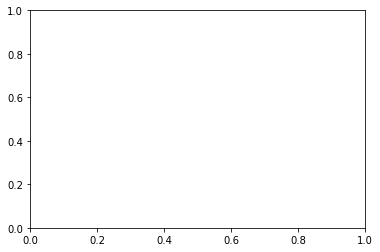

In [91]:
fig, ax = plt.subplots(1, 1)
n = 10
colors = [plt.cm.tab10(i) for i in range(n)]
for i, halo in enumerate(rs_subset[0:n]): # subset should already be random
    logt_target, log_mah_target, lgtarr, log_mah_fit = fit_halo(halo, forest)
    __=ax.plot(logt_target, log_mah_target, color = colors[i])
    __=ax.plot(lgtarr, log_mah_fit, linestyle = "--", color = colors[i])

[ 0.      0.0245  0.0502  0.0749  0.1008  0.1279  0.1538  0.1837  0.2123
  0.2423  0.2705  0.3035  0.3347  0.3636  0.4017  0.4337  0.4714  0.5022
  0.5391  0.5777  0.6184  0.6557  0.6948  0.7358  0.7788  0.824   0.8646
  0.9143  0.9591  1.006   1.0552  1.1069  1.152   1.2088  1.2584  1.321
  1.3759  1.4334  1.4938  1.5443  1.6104  1.68    1.7384  1.7994  1.8797
  1.9472  2.018   2.0923  2.1703  2.2524  2.3168  2.4068  2.4775  2.5765
  2.6545  2.7361  2.8506  2.9412  3.0361  3.102   3.205   3.3133  3.4273
  3.5475  3.6313  3.763   3.8551  4.      4.1015  4.2618  4.3743  4.4918
  4.6145  4.7429  4.9467  5.0909  5.2422  5.3208  5.4839  5.6556  5.8367
  6.028   6.1277  6.3358  6.5564  6.6718  6.9134  7.04    7.3058  7.4454
  7.7391  7.8938  8.0541  8.3925  8.5714  8.7573  9.1515  9.3608  9.5789
  9.8065 10.044 ]
[      -inf       -inf       -inf       -inf       -inf       -inf
       -inf       -inf       -inf       -inf       -inf       -inf
       -inf  8.5644865  8.855757   9.197581   

/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


AxisError: axis 1 is out of bounds for array of dimension 1

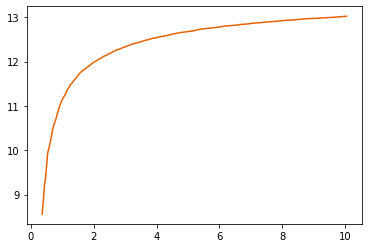

In [87]:
# find average mass evol history in each category
#colors = [plt.cm.tab10(i) for i in range(n)]
color_labels = ["all halos", "FG candidates", "QH candidates"]
colors = ["#E66100", "#5D3A9B", "#00805D"]

fig, ax = plt.subplots(1, 1)
for i, (this_subset, this_forest) in enumerate(zip([rs_subset, fg_subset, qh_subset], [forest, fg_forest, fg_forest])):
    mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(this_subset, this_forest)
    avg_mainbranch_masses = np.average(mainbranch_masses, axis = 0)
    
    print(redshifts)
    print(np.log10(avg_mainbranch_masses))
    ax.plot(redshifts, np.log10(avg_mainbranch_masses), color = colors[i], label = "M(z): " + color_labels[i])
    #logt_target, log_mah_target, lgtarr, log_mah_fit = fit_halo(np.array([avg_mainbranch_masses]), this_forest, use_halo_id = False)
    logt_target, log_mah_target, lgtarr, log_mah_fit = fit_halo(np.array(avg_mainbranch_masses), this_forest, use_halo_id = False)
    ax.plot(redshifts, log_mah_fit, linestyle = "-.", color = colors[i], label = "diffmah fit: " + color_labels[i]) # diffmah fit
    ax.set_ylim(bottom = 10)  
    ax.legend(loc = "lower right")
fig.savefig("diffmah_checks/diffmah_of_avg.png")

#### what I did before

In [ ]:
rs_avg_peakmass = np.average(ss_mainbranch_peakmass[0:1000], axis = 0)
fg_avg_peakmass = np.average(ss_mainbranch_peakmass[1000:2000], axis = 0)
rug_avg_peakmass = np.average(ss_mainbranch_peakmass[2000:2300], axis = 0)

rs_avg_tt = np.average(pickled_params['transition_time'][0:1000], axis = 0)
fg_avg_tt = np.average(pickled_params['transition_time'][1000:2000], axis = 0)
rug_avg_tt = np.average(pickled_params['transition_time'][2000:2300], axis = 0)
#print(rs_avg_tt, fg_avg_tt, rug_avg_tt)

In [ ]:
tpeak = cosmic_time[np.argmax(mainbranch_peakmass, axis=1)]
min_mass = 100*simulation.particle_mass

fig, ax = plt.subplots(1, 1)
colors = iter(["orange", "purple", "green"])
labels = iter(["random sample", "FG candidates", "rugged individualists"])
for this_peakmass, this_avg_tt in zip([rs_avg_peakmass, fg_avg_peakmass, rug_avg_peakmass], [rs_avg_tt, fg_avg_tt, rug_avg_tt]):
    current_color = next(colors)
    current_label = next(labels)f

    p_init, loss_data = get_loss_data(cosmic_time, this_peakmass, np.log10(min_mass)) # np.log10(log_mah_sim[ihalo])
    n_step = 150 # or  200?
    _res = jax_adam_wrapper(log_mah_mse_loss_and_grads, p_init, loss_data, n_step, n_warmup=1)
    p_best, loss, loss_arr, params_arr, fit_terminates = _res
    logtc, ue, ul = p_best
    logt_target, log_mah_target, logtmp, k, logmp_fit = loss_data
    early, late = _get_early_late(ue, ul) 
    tarr = np.linspace(0.75, 13.8, 500) # age of the universe things?
    lgtarr = np.log10(tarr)
    dmhdt_fit, log_mah_fit = _calc_halo_history(lgtarr, lgtarr[-1], logmp_fit, logtc, k, early, late) # Is logtc the new x0?
    
    # Plot average of mahs
    ax.plot(logt_target, log_mah_target, linestyle = '-', color = current_color, label = current_label)
    ax.axvline(this_avg_tt, linestyle = '-', color = current_color)

    # Plot diffmah of average
    ax.plot(lgtarr, log_mah_fit, linestyle = ':', color = current_color)
    ax.axvline(logtc, linestyle = ':', color = current_color)
    
    # Print best-fit params (for diffmah of the avg)
    print(current_label)
    print("early: ", early)
    print("late: ", late)
    print("transition time: ", logtc, "\n")
    
ax.legend()
ax.set_ylabel("log(peakmass)")
ax.set_xlabel("log(cosmic_time)")
fig.savefig("diffmah_averages.png")

#### average of diffmah

#### compare to overall average

## Plot

#### Helper Functions

In [196]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
def _contour_level(data, levels):
    data_flat = np.sort(data.flatten())[::-1]
    data_cm = np.cumsum(data_flat)
    assert data_cm[-1] <= 1.00001
    contour_level = np.empty(len(levels))
    for i, l in enumerate(levels):
        try:
            contour_level[i] = data_flat[data_cm <= l][-1]
        except:
            contour_level[i] = data_flat[0]  # If there is no element with data_cm <= l
    return np.sort(contour_level)  # sort, because contour plot requires levels in ascending order
def _plot_1d_hist(data, bins, ax, kde=True, **kwargs):
    if kde:
        kernel = scipy.stats.gaussian_kde(data)
        hist = kernel(bins)
        ax.plot(bins, hist, **kwargs)
    else:
        ax.hist(data, bins=bins, histtype='step', **kwargs)
def _plot_2d_hist(data_x, data_y, bins_x, bins_y, ax, levels, kde=True, **kwargs):
    if kde:
        kernel = scipy.stats.gaussian_kde(np.vstack((data_x, data_y)))
        xx, yy = np.meshgrid(bins_x, bins_y, indexing='ij')
        hist2d = kernel(np.vstack((xx.ravel(), yy.ravel()))).reshape(xx.shape)
    else:
        hist2d, _, _, = np.histogram2d(data_x, data_y, [bins_x, bins_y])
        bins_x = 0.5*(bins_x[1:] + bins_x[:-1])
        bins_y = 0.5*(bins_y[1:] + bins_y[:-1])
    # find contour levels
    hist2d /= np.sum(hist2d)
    clevs = _contour_level(hist2d, levels)
    if 'linewidth' in kwargs:
        kwargs['linewidths'] = kwargs['linewidth'] #- 0.5
    if 'linestyle' in kwargs:
        kwargs['linestyles'] = [kwargs['linestyle']]
    ax.contour(bins_x, bins_y, hist2d.T, levels=clevs, **kwargs)
    return fig, ax

#### Plotting Function

In [185]:
def jointplot(
        *data, # Unpackable? Aha, because you can have multiple sets
        levels=[0.1, 0.5, 0.9], 
        colors=None,
        linestyles=None,
        bin_edges=None, 
        prop_labels=None,
        data_labels=None,
        fig=None,
        **kwargs):
    ndata = len(data) # Number of data sets (for us, this is 3)
    nprops = data[0].shape[1] # Number of properties
    # consistency checks
    assert np.all([data[i].shape[1] == nprops for i in range(ndata)])
    if bin_edges is not None:
        assert len(bin_edges) == nprops
    if prop_labels is not None:
        assert len(prop_labels) == nprops
    else:
        prop_labels = [f'prop {p}' for p in range(nprops)] # Why is this sometimes f and sometimes r?
    if data_labels is not None:
        assert len(data_labels) == ndata
    else:
        data_labels = [f'data {i}' for i in range(ndata)]
    # colors
    if colors is None:
        if ndata <= 10:
            colors = [plt.cm.tab10(i) for i in range(ndata)]
        else:
            raise NotImplementedError("please specify colors")
    # linestyles      
    if linestyles is None:
        linestyles = np.resize('-', ndata)
    # Creating figure and axes
    if fig is None:
        fig = plt.figure(figsize=(10, 10))
    gs = plt.matplotlib.gridspec.GridSpec(nprops, nprops, figure=fig, hspace=0, wspace=0)
    axes = np.array([[
            fig.add_subplot(gs[i, j]) if j <= i else None
            for j in range(nprops)]
        for i in range(nprops)])
    # Finding bin edges
    if bin_edges is None:
        bin_edges = [(
            min(np.min(data[i][:, p]) for i in range(ndata)),
            max(np.max(data[i][:, p]) for i in range(ndata))
            ) for p in range(nprops)]
        #print(bin_edges)
        # default nbins=50
        bin_edges = [
            np.linspace(*be, 51, endpoint=True) for be in bin_edges
        ]
        #print(bin_edges)
    # Doing 1D histograms
    for p in range(nprops):
        for i in range(ndata):
            _plot_1d_hist(
                data[i][:, p], 
                bin_edges[p], 
                axes[p, p],
                color=colors[i],
                label=data_labels[i],
                linestyle = linestyles[i],
                **kwargs
            )
    # Doing 2D histograms
    for py in range(nprops):
        for px in range(py):
            for i in range(ndata):
                _plot_2d_hist(
                    data[i][:, px], 
                    data[i][:, py], 
                    bin_edges[px], 
                    bin_edges[py], 
                    axes[py, px], 
                    levels=levels, 
                    colors=colors[i], 
                    linestyle = linestyles[i], 
                    **kwargs 
                )
    # Setting limits
    for py in range(nprops): # 0 to 7
        for px in range(py+1): # 0 to 1, 0 to 2, 0 to 3,... 0 to 8
            axes[py, px].set_xlim(bin_edges[px][[0,-1]]) # always set these limits
            if px < py:
                axes[py, px].set_ylim(bin_edges[py][[0,-1]]) # only set the limits below the diagonal
            if py == nprops-1:
                axes[py, px].set_xlabel(prop_labels[px]) # only set the x labels when you're on the last y (highest?) I guess that's when you look at the whole x-axis. All labels at once, I guess?
            else:
                axes[py, px].set_xticklabels([]) # if not on the last y (highest), set the x ticks
            if px == 0 and py > 0:
                axes[py, px].set_ylabel(prop_labels[py]) # only set the y labels when climbing up the y side (but do it all at once)
            else:
                axes[py, px].set_yticklabels([]) # set y-ticks everywhere else (not just when climbing up the y side)
    # Removing boundaries from diagonal plots
    for p in range(nprops):
        axes[p, p].set_ylim(bottom=0)
        axes[p, p].spines['top'].set_visible(False)
        axes[p, p].spines['right'].set_visible(False)
        axes[p, p].spines['left'].set_visible(False)
        axes[p, p].xaxis.set_ticks_position('bottom')
        axes[p, p].set_yticks([])
        # make background transparent
        axes[p, p].set_facecolor("none")
    # Setting labels
    return fig, axes


### Implement

/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: The following kwargs were not used by contour: 'linestyle', 'linewidth'


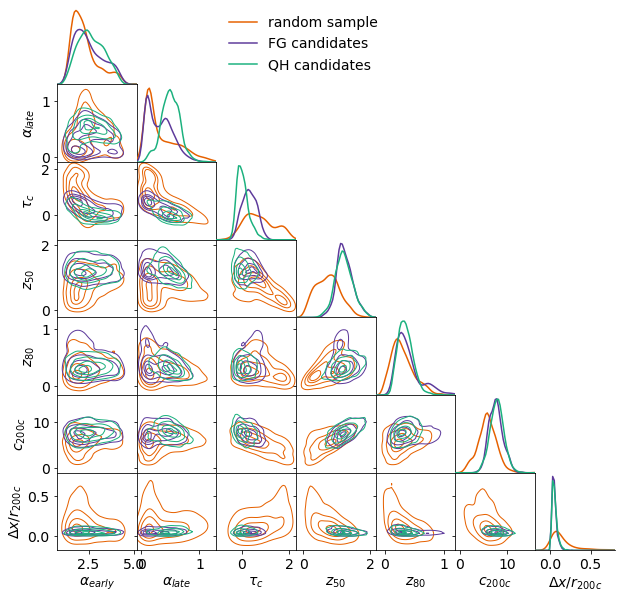

In [150]:
plt.rcParams.update({
    'font.size': 14,
    "figure.figsize": (10, 10), #(5.2, 3.13), #(5.4, 3.25), #(5.83, 3.5),#(6.25, 4.25), #(6.25, 3.75)
})

global_mins = [np.Inf for p in range(pickled_rs_params.shape[1])] # HARD CODE (but should all be the same?)
global_maxs = [-np.Inf for p in range(pickled_rs_params.shape[1])]
for data in [pickled_rs_params, pickled_fg_params, pickled_qh_params]:
    mins = [np.min(data[:, p]) for p in range(data.shape[1])] # list containing min value of each property
    maxs = [np.max(data[:, p]) for p in range(data.shape[1])] # data.shape[1] = nparams 
    global_mins = [min(mins[p], global_mins[p]) for p in range(data.shape[1])]
    global_maxs = [max(maxs[p], global_maxs[p]) for p in range(data.shape[1])]

basic_bin_edges = [(global_mins[p], global_maxs[p]) for p in range(1, data.shape[1])]
bin_edges = [(global_mins[p] - 0.1*(global_maxs[p] - global_mins[p]), global_maxs[p]) for p in range(1, data.shape[1])]
bin_edges[4] = (bin_edges[4][0], 1.2) # Manually adjust max for z80s and relaxations
bin_edges[6] = (bin_edges[6][0], 0.8)
bin_edges = [np.linspace(*be, 51, endpoint=True) for be in bin_edges]

fig = plt.figure()
colors = ["#E66100", "#5D3A9B", "#1BB17E"] #green "#009E73" # light blue "#5AC8E9"]# blue "#1AA3CB"]"#CC6677"
#print(pickled_rs_params[0,1:])
fig, axes = jointplot(pickled_rs_params[:,1:], pickled_fg_params[:,1:], pickled_qh_params[:,1:], levels=[0.1, 0.35, 0.65, 0.9], prop_labels = [r"$\alpha_{early}$", r"$\alpha_{late}$", r"$\tau_c$", r"$z_{50}$", r"$z_{80}$", r"$c_{200c}$", r"$\Delta x/r_{200c}$"], data_labels = ["random sample", "FG candidates", "QH candidates"], bin_edges = bin_edges, colors = colors, fig=fig, linewidth = 1.5)
axes[1,1].legend(loc='lower left', bbox_to_anchor=(1,1), frameon=False)
fig.savefig("diffmah_new.png")

## Non-overlapping Samples

In [151]:
%%time
# Pick a mass bin
mass_bin = 0
my_fg_mask = fg_masks[mass_bin]
my_halo_mask = halo_masks[mass_bin]

# Find fgs within forest
rs_fg_qh_idx = np.nonzero(my_halo_mask)[0]
rs_fg_qh_mainbranch_index, rs_fg_qh_mainbranch_masses = help_func_haccytrees.get_branches(rs_fg_qh_idx, forest)
rs_fg_qh_mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(forest, progenitor_array, rs_fg_qh_mainbranch_index)
rs_fg_qh_major_mergers = help_func_haccytrees.get_major_mergers(rs_fg_qh_mainbranch_mergers)
rs_fg_qh_lmm_redshift = help_func_haccytrees.get_lmms(rs_fg_qh_major_mergers)
rs_fgs, rs_qhs, mrich = help_func_haccytrees.find_specials(forest, rs_fg_qh_mainbranch_index, rs_fg_qh_major_mergers, rs_fg_qh_lmm_redshift, rs_fg_qh_idx)
non_idx = np.delete(rs_fg_qh_idx, np.concatenate((np.argwhere(np.isin(rs_fg_qh_idx, rs_qhs)), np.argwhere(np.isin(rs_fg_qh_idx, rs_fgs)))))

# Find qhs within fg_forest
fg_qh_idx = np.nonzero(my_fg_mask)[0]
fg_qh_mainbranch_index, fg_qh_mainbranch_masses = help_func_haccytrees.get_branches(fg_qh_idx, fg_forest)
fg_qh_mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(fg_forest, fg_progenitor_array, fg_qh_mainbranch_index)
fg_qh_major_mergers = help_func_haccytrees.get_major_mergers(fg_qh_mainbranch_mergers)
fg_qh_lmm_redshift = help_func_haccytrees.get_lmms(fg_qh_major_mergers)
fgs, qhs, mrich = help_func_haccytrees.find_specials(fg_forest, fg_qh_mainbranch_index, fg_qh_major_mergers, fg_qh_lmm_redshift, fg_qh_idx)
fg_idx = np.delete(fg_rugs_idx, np.argwhere(np.isin(fg_qh_idx, qhs)))

# Define sample sizes
non_sample_size = 1000
fg_sample_size = 1000
if qhs != []:
    qh_sample_size = 1000 #len(rugs)
    size = fg_sample_size + qh_sample_size + non_sample_size
else:
    qh_sample_size = 0 #len(rugs)
    size = fg_sample_size + non_sample_size
    
# Create subsets
np.random.seed(0)
rs_subset = np.random.choice(non_idx, non_sample_size)
fg_subset = np.random.choice(fg_idx, fg_sample_size)
if qhs != []:
    qh_subset = np.random.choice(qhs, qh_sample_size)

CPU times: user 5.18 s, sys: 12.8 s, total: 18 s
Wall time: 3.71 s


/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [74]:
%%time
#rs_tpeak = cosmic_time[np.argmax(rs_subset, axis=1)] # Do we still need this part?
non_best_fit_params = calc_subset_params(rs_subset, forest) # p_init is shape of number of params. How many params do I have? 3 fg, rugs, rs, but are those really parameters?
fg_only_best_fit_params = calc_subset_params(fg_subset, fg_forest) 
qh_only_best_fit_params = calc_subset_params(qh_subset, fg_forest)

/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


CPU times: user 33min 18s, sys: 5min 49s, total: 39min 7s
Wall time: 28min 50s


In [75]:
pickle.dump(non_best_fit_params, open( "save_new_non_list.p", "wb" ))
pickle.dump(fg_only_best_fit_params, open( "save_new_fg_only_list.p", "wb" ))
pickle.dump(qh_only_best_fit_params, open( "save_new_qh_only_list.p", "wb" ))

pyfftw not available, using numpy fft


In [76]:
pickled_non_params = pickle.load( open( "save_new_non_list.p", "rb" ))
pickled_fg_only_params = pickle.load( open( "save_new_fg_only_list.p", "rb" ))
pickled_qh_only_params = pickle.load( open( "save_new_qh_only_list.p", "rb" ))

/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: The following kwargs were not used by contour: 'linestyle', 'linewidth'


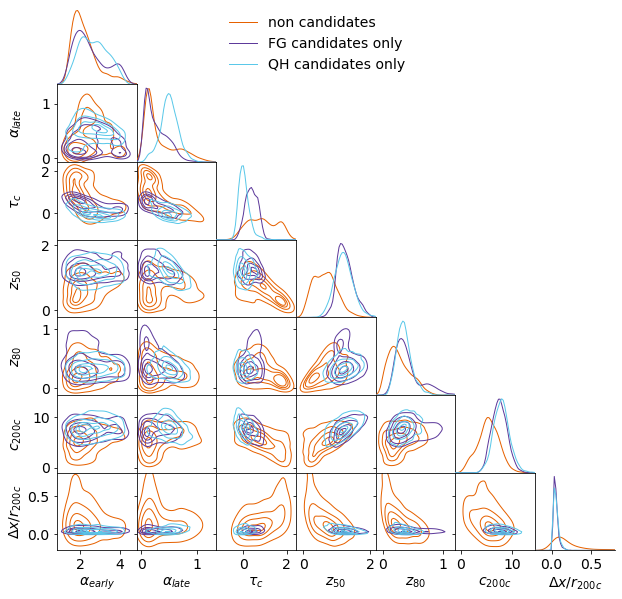

In [91]:
plt.rcParams.update({
    'font.size': 14,
    "figure.figsize": (10, 10), #(5.2, 3.13), #(5.4, 3.25), #(5.83, 3.5),#(6.25, 4.25), #(6.25, 3.75)
})

global_mins = [np.Inf for p in range(pickled_non_params.shape[1])] # HARD CODE (but should all be the same?)
global_maxs = [-np.Inf for p in range(pickled_non_params.shape[1])]
for data in [pickled_non_params, pickled_fg_only_params, pickled_qh_only_params]:
    mins = [np.min(data[:, p]) for p in range(data.shape[1])] # list containing min value of each property
    maxs = [np.max(data[:, p]) for p in range(data.shape[1])] # data.shape[1] = nparams 
    global_mins = [min(mins[p], global_mins[p]) for p in range(data.shape[1])]
    global_maxs = [max(maxs[p], global_maxs[p]) for p in range(data.shape[1])]

basic_bin_edges = [(global_mins[p], global_maxs[p]) for p in range(1, data.shape[1])]
bin_edges = [(global_mins[p] - 0.1*(global_maxs[p] - global_mins[p]), global_maxs[p]) for p in range(1, data.shape[1])]
bin_edges[4] = (bin_edges[4][0], 1.2) # Manually adjust max for z80s and relaxations
bin_edges[6] = (bin_edges[6][0], 0.8)
bin_edges = [np.linspace(*be, 51, endpoint=True) for be in bin_edges]

fig = plt.figure()
colors = ["#E66100", "#5D3A9B", "#5AC8E9"] #green "#009E73" # light blue "#5AC8E9"]# blue "#1AA3CB"]"#CC6677" # other green "#1BB17E"
#print(pickled_rs_params[0,1:])
fig, axes = jointplot(pickled_non_params[:,1:], pickled_fg_only_params[:,1:], pickled_qh_only_params[:,1:], levels=[0.1, 0.35, 0.65, 0.9], prop_labels = [r"$\alpha_{early}$", r"$\alpha_{late}$", r"$\tau_c$", r"$z_{50}$", r"$z_{80}$", r"$c_{200c}$", r"$\Delta x/r_{200c}$"], data_labels = ["non candidates", "FG candidates only", "QH candidates only"], bin_edges = bin_edges, colors = colors, fig=fig, linewidth = 1)#, linestyles = ['--', '-', '-.'])
axes[1,1].legend(loc='lower left', bbox_to_anchor=(1,1), frameon=False)

fig.align_ylabels(axes[:, 0])
fig.savefig("diffmah_new_distinct.png")

### Possible Final Version?

/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: The following kwargs were not used by contour: 'linestyle', 'linewidth'


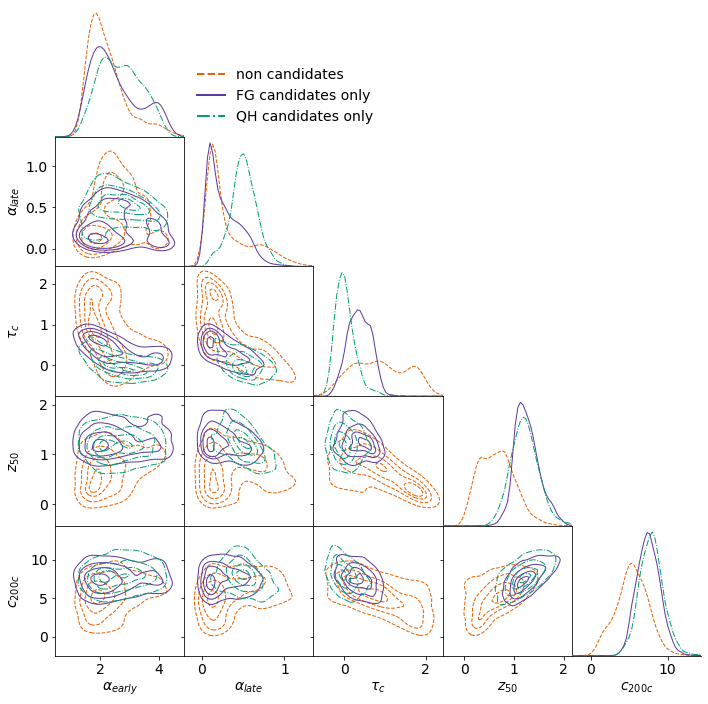

In [218]:
plt.rcParams.update({
    'font.size': 14,
    "figure.figsize": (10, 10), #(5.2, 3.13), #(5.4, 3.25), #(5.83, 3.5),#(6.25, 4.25), #(6.25, 3.75)
})

prop_labels = np.array([r"$M_{z=0}$", r"$\alpha_{early}$", r"$\alpha_{late}$", r"$\tau_c$", r"$z_{50}$", r"$z_{80}$", r"$c_{200c}$", r"$\Delta x/r_{200c}$"])

# Okay fine...
global_mins = [np.Inf for p in range(pickled_non_params.shape[1])] # HARD CODE (but should all be the same?)
global_maxs = [-np.Inf for p in range(pickled_non_params.shape[1])]
for data in [pickled_non_params, pickled_fg_only_params, pickled_qh_only_params]:
    mins = [np.min(data[:, p]) for p in range(data.shape[1])] # list containing min value of each property
    maxs = [np.max(data[:, p]) for p in range(data.shape[1])] # data.shape[1] = nparams
    global_mins = [min(mins[p], global_mins[p]) for p in range(data.shape[1])]
    global_maxs = [max(maxs[p], global_maxs[p]) for p in range(data.shape[1])]
    
bin_edges = [(global_mins[p] - 0.2*(global_maxs[p] - global_mins[p]), global_maxs[p]) for p in range(data.shape[1])]
bin_edges[3] = (-0.75, bin_edges[3][1])
bin_edges[5] = (bin_edges[5][0], 1.2) # Manually adjust max for z80s and relaxations
bin_edges[7] = (bin_edges[7][0], 0.8)
bin_edges = np.array([np.linspace(*be, 51, endpoint=True) for be in bin_edges])

fig = plt.figure()
colors = ["#E66100", "#5D3A9B", "#009E73"] #green "#009E73" # light blue "#5AC8E9"]# blue "#1AA3CB"]"#CC6677" # other green "#1BB17E"
#data = [np.concatenate((pickled_non_params[:,1:5], [pickled_non_params[:,6]]), axis = 1), np.concatenate((pickled_fg_only_params[:,1:5], [pickled_fg_only_params[:,6]]), axis = 1), np.concatenate((pickled_qh_only_params[:,1:5], [pickled_qh_only_params[:,6]]), axis = 1)]
#print(type(pickled_non_params))
fig, axes = jointplot(pickled_non_params[:,[1,2,3,4,6]], pickled_fg_only_params[:,[1,2,3,4,6]], pickled_qh_only_params[:,[1,2,3,4,6]], levels=[0.1, 0.35, 0.65, 0.9], prop_labels = prop_labels[[1,2,3,4,6]], data_labels = ["non candidates", "FG candidates only", "QH candidates only"], bin_edges = bin_edges[[1,2,3,4,6]], colors = colors, fig=fig, linewidth = 1, linestyles = ['--', '-', '-.'])
leg = axes[1,1].legend(loc='lower left', bbox_to_anchor=(0,1), frameon=False)
for line in leg.get_lines():
    line.set_linewidth(2.0)
fig.align_ylabels(axes[:, 0])
plt.tight_layout()
fig.savefig("full_lj_plots/diffmah_favs.png", bbox_inches='tight', pad_inches=0)

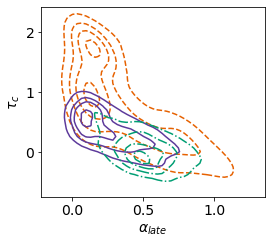

In [206]:
# Zoom in on a_late vs. tau_c
plt.rcParams.update({
    'font.size': 14,
    #"figure.figsize": (5, 3.25), #(5.2, 3.13), #(5.4, 3.25), #(5.83, 3.5),#(6.25, 4.25), #(6.25, 3.75)
})

fig, ax = plt.subplots(figsize = (4,3.5))
colors = ["#E66100", "#5D3A9B", "#009E73"]
linestyles =['--', '-', '-.']
for i, data in enumerate([pickled_non_params[:,[2,3]], pickled_fg_only_params[:,[2,3]], pickled_qh_only_params[:,[2,3]]]):
    fig, ax = _plot_2d_hist(data[:,0], data[:,1], bin_edges[[2,3][0]], bin_edges[[2,3][1]], levels=[0.1, 0.35, 0.65, 0.9], ax = ax, colors = colors[i], linestyles = linestyles[i])

ax.set_ylabel(prop_labels[3])
ax.set_xlabel(prop_labels[2])
    
#plt.tight_layout()
fig.savefig("full_lj_plots/diffmah_alate_tauc.pdf", bbox_inches='tight', pad_inches=0)

#### Example

In [13]:
nprops = 3
ndata = 1000
cov0 = np.random.uniform(-1, 1, (nprops, nprops))
cov0 = np.dot(cov0, cov0.T)
m0 = np.random.normal(0, 1, nprops) + np.arange(nprops)
data0 = np.random.multivariate_normal(m0, cov0, ndata)
print(data0)
cov1 = np.random.uniform(-1, 1, (nprops, nprops))
cov1 = np.dot(cov1, cov1.T)
m1 = np.random.normal(0, 1, nprops)+np.arange(nprops)
data1 = np.random.multivariate_normal(m1, cov1, ndata)

[[-0.40187937  1.88343555  0.87751274]
 [ 0.12837835  1.77769819  1.19790822]
 [ 0.02123759  0.72135965  2.8711901 ]
 ...
 [-0.57225079  1.37964867  2.90170433]
 [-1.22913857  1.20498004  4.47624081]
 [-0.75788443  3.01046853 -0.43687521]]


In [198]:
fig = plt.figure(figsize=(8,8))
fig, axes = jointplot(data0, data1, levels=[0.1, 0.5, 0.9], fig=fig)
axes[1,1].legend(loc='lower left', bbox_to_anchor=(1,1), frameon=False)

TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 576x576 with 6 Axes>

In [180]:
print([i for i in range(9)])

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [21]:
%%time
np.array(pickled_params['alpha_early']).T

CPU times: user 124 µs, sys: 3 µs, total: 127 µs
Wall time: 335 µs


array([3.85562968, 1.53492582, 2.05148697, ..., 2.19705725, 2.15747094,
       3.71588826])

In [22]:
print(list(pickled_params))

['final_mass', 'alpha_early', 'alpha_late', 'transition_time', 'rs_fg_rug', 'z50s', 'z80s']
